# <center> Analyse données EDC3 - BCG </center>
# <center> Groupe 7 </center>
### <center> Dargier Antoine </center>
### <center> Demoulin Aurore </center>
### <center> Henin Martin </center>
### <center> Kuntz Paul </center>

Nous allons ici mettre en place une analyse détaillée des données de ClientCo. Après une première analyse pour dresser un premier bilan de l'entreprise, nous essayerons de mettre en place un algorithme de prévision du churn, qui permettera de repérer les clients succeptibles de partir et de mettre en place des réponses adaptés aux raisons de leur départ.

# Sommaire

* [0. Import des modules et chargement des données](#chapter0)
* [1. Analyses préliminaires](#chapter1)
    * [1.1 Analyse des canaux](#section_1_1)
    * [1.2 Analyse du CA](#section_1_2)
    * [1.3 Analyse volume](#section_1_3)
    * [1.4 Analyse délai de paiement](#section_1_4)
    * [1.5 Analyse clients](#section_1_5)
    * [1.6 Analyse produits](#section_1_6)
    * [1.7 Analyse retours](#section_1_7)
    * [1.8 Conclusion](#section_1_8)
* [2. Analyse churn/Préparation des données](#chapter2)
    * [2.1 Enlever clients avec moins de X commandes](#section_2_1)
    * [2.2 Enlever les n derniers mois, qui servent à définir les churners](#section_2_2)
    * [2.3 Calcul du chrun rate](#section_2_3)
    * [2.4 Mise en place des features](#section_2_4)
        * [2.4.1 Fréquence : temps entre deux commandes](#section_2_4_1)
        * [2.4.2 Séparation des X dernières commandes](#section_2_4_2)
        * [2.4.3 Moyenne fréquences des X dernières commandes vs. all](#section_2_4_3)
        * [2.4.4 Nombre retours dans les X dernières commandes](#section_2_4_4)
        * [2.4.5 Moyenne dépenses des X dernières commandes vs. all](#section_2_4_5)
        * [2.4.6 Délai de paiement des X dernières commandes vs. all](#section_2_4_6)
        * [2.4.7 Moyenne des dépenses](#section_2_4_7)
        * [2.4.8 Fréquence de commande moyenne](#section_2_4_8)
        * [2.4.9 Répartition des commandes par canal de distribution](#section_2_4_9)
        * [2.4.10 Ancienneté du client](#section_2_4_10)
        * [2.4.11 Temps depuis la dernière commande](#section_2_4_11)
        * [2.4.12 Nombre de commandes passées](#section_2_4_12)
    * [2.5 Création de la table des features](#section_2_5)
    * [2.6 Création des outputs](#section_2_6)
* [3. Algorithmes de prévision du churn](#chapter3)
    * [3.1 Importation des packages](#section_3_1)
    * [3.2 Chargement des données](#section_3_2)
    * [3.3 Premières observations des features](#section_3_3)
    * [3.4 Sélection des features](#section_3_4)
    * [3.5 Normalisation des données](#section_3_5)
    * [3.6 Division en set de train et test](#section_3_6)
    * [3.7 Regression logistiques](#section_3_7)
    * [3.8 Support Vector Machine](#section_3_8)
    * [3.9 K Nearest Neighbor](#section_3_9)
    * [3.10 Random Forest](#section_3_10)
    * [3.11 Gradient Boosting Regression](#section_3_11)
* [4. Evaluation des performances](#chapter4)
* [5. Conclusion générale](#chapter5)

# 0. Import des modules et chargement des données <a class="anchor" id="chapter0"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.tseries.offsets import DateOffset

In [2]:
df_data = pd.read_csv("C:/Users/antoi/Documents/dataset_sales_2.csv", delimiter = ";", parse_dates=['date_order', 'date_invoice'])

In [52]:
df_data.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,pay_term
0,2017-09-25,2017-09-25,2376333,188502,155.44320,3,online,2732,0.0
1,2017-09-25,2017-09-25,2520527,835089,16.39440,3,at the store,10279,0.0
2,2017-09-25,2017-09-25,2536756,1977896,365.76624,21,online,6184,0.0
3,2017-09-25,2017-09-25,3028673,598816,8.59878,201,at the store,4200,0.0
4,2017-09-25,2017-09-25,203377,2086861,1093.37400,3,by phone,7051,0.0


In [6]:
df_data.shape

(63319315, 8)

# 1. Analyses préliminaires <a class="anchor" id="chapter1"></a>

## 1.1 Analyse des canaux <a class="anchor" id="section_1_1"></a>

at the store                       0.507179
by phone                           0.402171
online                             0.089260
other                              0.000928
during the visit of a sales rep    0.000463
Name: order_channel, dtype: float64


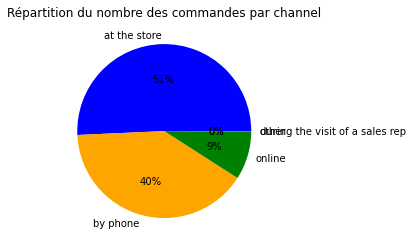

In [308]:
#nb de commande par channel
Nb_commande = df_data.order_channel.value_counts("at the store")
print(Nb_commande)

labels = ['at the store', 'by phone', 'online', 'other', 'during the visit of a sales rep']
colors = ['blue','orange','green','red', 'purple']
plt.pie(Nb_commande, labels=labels, colors = colors, autopct = '%0.0f%%')
plt.title("Répartition du nombre des commandes par channel")
plt.show()

                                 sales_net
order_channel                             
at the store                      0.261552
by phone                          0.643726
during the visit of a sales rep   0.000795
online                            0.092983
other                             0.000945


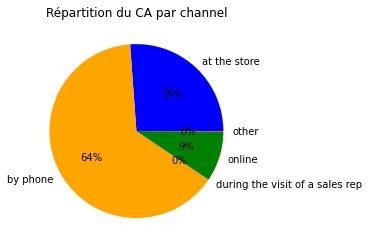

In [309]:
#CA par channel
Sales_by_channel = df_data[["sales_net", "order_channel"]]
df_sbc = Sales_by_channel.groupby(["order_channel"]).agg("sum")
tot = df_sbc.sales_net.sum()
df_sbc["sales_net"] = df_sbc["sales_net"]/tot
print(df_sbc)

labels = ['at the store', 'by phone', 'during the visit of a sales rep', 'online', 'other']
colors = ['blue','orange', 'purple', 'green','red']
plt.pie(df_sbc["sales_net"], labels = labels, colors = colors, autopct = '%0.0f%%')
plt.title("Répartition du CA par channel")
plt.show()

## 1.2 Analyse du CA <a class="anchor" id="section_1_2"></a>

C:\Users\antoi\AppData\Local\Temp\ipykernel_5568\2111699418.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca_an_channel["year_order"] = pd.to_datetime(df_ca_an_channel["date_order"]).dt.year


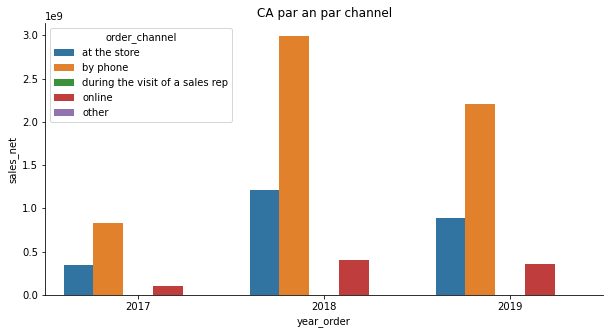

In [21]:
# CA par an par channel
df_ca_an_channel = df_data[["date_order", "order_channel", "sales_net"]]
df_ca_an_channel["year_order"] = pd.to_datetime(df_ca_an_channel["date_order"]).dt.year
df_caac = df_ca_an_channel[["year_order", "order_channel", "sales_net"]]
df_caac = df_caac.groupby(["year_order", "order_channel"]).agg("sum").reset_index()

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x = "year_order", hue = "order_channel", y = "sales_net", data = df_caac, ax=ax).set(title='CA par an par channel')
sns.despine()

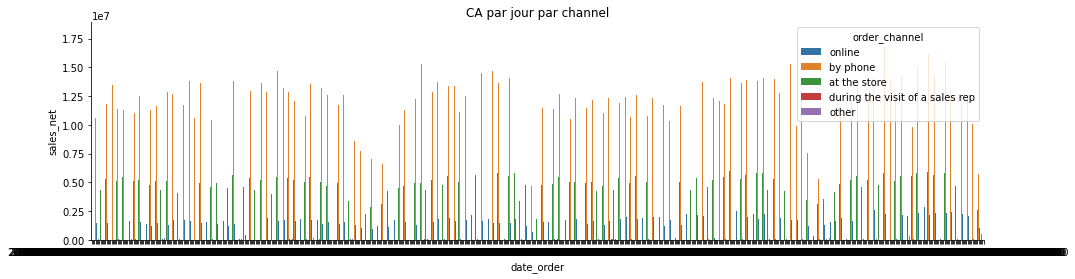

In [310]:
df_sales_channel = df_data[["date_order", "sales_net", "order_channel"]]
df_sc = df_sales_channel.groupby(["date_order","order_channel"]).agg("sum").reset_index()

fig, ax = plt.subplots(figsize=(16,4))
sns.barplot(x = "date_order", hue = "order_channel", y = "sales_net", data = df_sc, ax=ax).set(title='CA par jour par channel')
sns.despine()

## 1.3 Analyse volume <a class="anchor" id="section_1_3"></a>

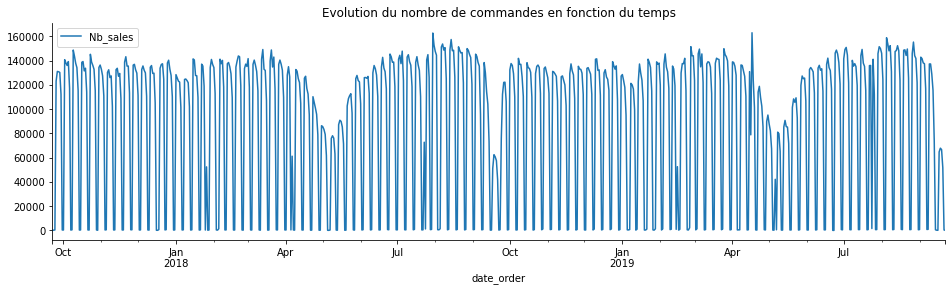

In [311]:
df_date = df_data[["date_order", "date_invoice"]]
df_date = df_date.groupby(["date_order"]).agg("count")
df_date = df_date.rename(columns={"date_invoice" : "Nb_sales"})

fig, ax = plt.subplots(figsize=(16,4))
df_date.plot(ax = ax)
plt.title("Evolution du nombre de commandes en fonction du temps")
sns.despine()

In [41]:
#nombre de ventes moyennes par jour
summary_nb_sales = df_date[["Nb_sales"]].describe()
print(summary_nb_sales)

            Nb_sales
count     731.000000
mean    86620.128591
std     60447.127624
min        22.000000
25%       712.500000
50%    119165.000000
75%    135660.500000
max    163093.000000


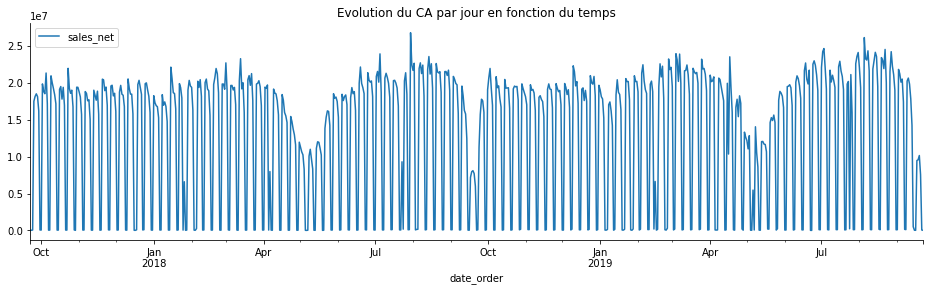

In [312]:
df_sales = df_data[["date_order", "sales_net"]]
df_sales = df_sales.groupby(["date_order"]).agg("sum")

fig, ax = plt.subplots(figsize=(16,4))
df_sales.plot(ax = ax)
plt.title("Evolution du CA par jour en fonction du temps")
sns.despine()

In [42]:
#sales par jour
summary_sales = df_sales[["sales_net"]].describe()
print(summary_sales)

          sales_net
count  7.310000e+02
mean   1.281472e+07
std    9.012474e+06
min    4.748364e+03
25%    1.078924e+05
50%    1.768328e+07
75%    1.984874e+07
max    2.677870e+07


## 1.4 Analyse délai de paiement <a class="anchor" id="section_1_4"></a>

C:\Users\antoi\AppData\Local\Temp\ipykernel_3144\1308662055.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_delai_pai["delai"] = (df_delai_pai['date_invoice'] - df_delai_pai['date_order']).dt.days


         date_order date_invoice  delai
0        2017-09-25   2017-09-25    0.0
1        2017-09-25   2017-09-25    0.0
2        2017-09-25   2017-09-25    0.0
3        2017-09-25   2017-09-25    0.0
4        2017-09-25   2017-09-25    0.0
...             ...          ...    ...
63319310 2019-06-10   2020-06-12  368.0
63319311 2018-12-14   2020-07-15  579.0
63319312 2019-07-26   2020-10-29  461.0
63319313 2018-05-23   2020-11-27  919.0
63319314 2019-09-10   2020-10-20  406.0

[63319315 rows x 3 columns]


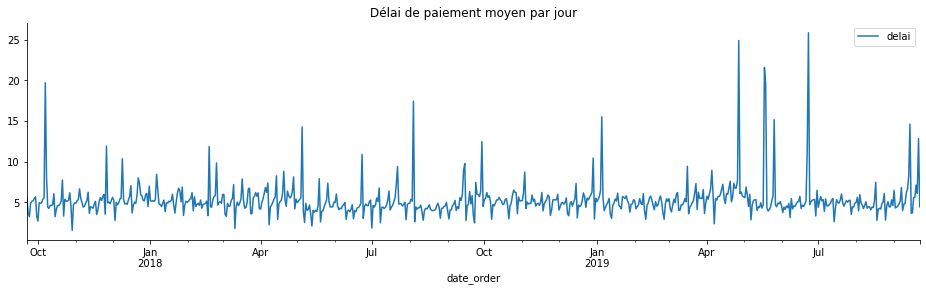

In [8]:
#étude délai de paiment en fonction du temps

df_delai_pai = df_data[["date_order", "date_invoice"]]
df_delai_pai["delai"] = (df_delai_pai['date_invoice'] - df_delai_pai['date_order']).dt.days
df_dp = df_delai_pai[["date_order","delai"]]

df_dp = df_dp.groupby("date_order").agg("mean")

fig, ax = plt.subplots(figsize=(16,4))
df_dp.plot(ax = ax)
plt.title("Délai de paiement moyen par jour")
sns.despine()

## 1.5 Analyse clients <a class="anchor" id="section_1_5"></a>

In [13]:
#nombre de clients
df_cli = df_data[["client_id", "sales_net"]]
df_cli = df_cli.groupby("client_id").agg("sum")
df_cli = df_cli.rename(columns={"sales_net" : "Dépenses par client"})
df_cli.describe()

,Dépenses par client
count,1.705890e+05
mean,5.491304e+04
std,2.438333e+05
min,-9.239541e+02
25%,1.271890e+03
50%,6.163601e+03
75%,2.933579e+04
max,2.755879e+07


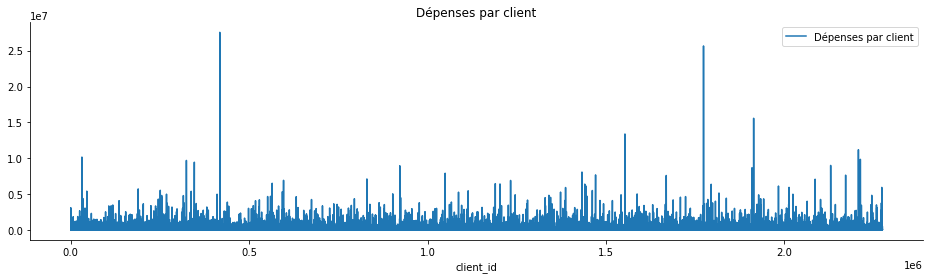

In [15]:
fig, ax = plt.subplots(figsize=(16,4))
df_cli.plot(ax = ax)
plt.title("Dépenses par client")
sns.despine()

In [10]:
#stat commandes par clients
df_client = df_data[["client_id", "date_order"]]
df_client = df_client.groupby("client_id").agg("count")
df_client = df_client.rename(columns={"date_order" : "Nb_commande par client"})
df_client.describe()

,Nb_commande par client
count,170589.000000
mean,371.180527
std,1430.183791
min,1.000000
25%,12.000000
50%,50.000000
75%,214.000000
max,105636.000000


## 1.6 Analyse produits <a class="anchor" id="section_1_6"></a>

In [25]:
#étude des produits : nb de ventes, prix moyens par produits, produits par channel
df_prod = df_data[["product_id", "quantity", "sales_net"]]
df_prod["mean_price"] = df_prod["sales_net"]/df_prod["quantity"]
df_prod = df_prod.groupby("product_id").agg({"quantity" : "sum", "sales_net" : "sum", "mean_price" : "mean"}).reset_index()
df_prod.describe()

C:\Users\antoi\AppData\Local\Temp\ipykernel_3144\512189848.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prod["mean_price"] = df_prod["sales_net"]/df_prod["quantity"]


,product_id,quantity,sales_net,mean_price
count,6.074180e+05,6.074180e+05,6.074180e+05,607418.000000
mean,1.621435e+06,9.606715e+03,1.542193e+04,177.653704
std,9.349275e+05,3.641801e+05,1.723732e+05,821.234972
min,1.500000e+01,3.000000e+00,-2.204999e+04,-3440.376800
25%,8.117628e+05,3.000000e+00,2.070000e+02,8.159697
50%,1.622726e+06,1.400000e+01,7.522314e+02,38.870000
75%,2.430560e+06,1.010000e+02,3.002880e+03,140.880713
max,3.238833e+06,8.340019e+07,3.980161e+07,231504.200000


## 1.7 Analyse retours <a class="anchor" id="section_1_7"></a>

In [23]:
#étudier les retours sales négatives = insatisfaction client. 2M de retours ??
df_retours = df_data[["sales_net", "product_id"]]
df_retours = df_retours.loc[df_retours["sales_net"]<0]
rep_retours = int(100*df_retours.shape[0]/df_data.shape[0])
print(f'Nombre de retours = {rep_retours}%')

df_retours = df_retours.groupby("product_id").agg("sum")
df_retours["sales_net"] = df_retours["sales_net"].abs()
df_retours = df_retours.rename(columns={"sales_net" : "Net_sales_retours_par_produit"})
ca_retours = df_retours.sum()
ca_tot = df_data["sales_net"].sum()
print(f'CA retours = {ca_retours["Net_sales_retours_par_produit"]}')
print(f'CA total = {ca_tot}')
print(f'% CA perdu par retours = {int(100*ca_retours["Net_sales_retours_par_produit"]/ca_tot)}%')
df_retours.describe()

Nombre de retours = 3%
CA retours = 577294226.3437922
CA total = 9367560275.589584
% CA perdu par retours = 6%


,Net_sales_retours_par_produit
count,1.344230e+05
mean,4.294609e+03
std,2.013707e+04
min,2.070000e-02
25%,1.717079e+02
50%,6.171360e+02
75%,2.301563e+03
max,1.738817e+06


In [26]:
#produits + retournés qu'achetés
df_prod_neg = df_prod.loc[df_prod["sales_net"]<0]
df_prod_neg = df_prod_neg[["product_id", "sales_net"]]
df_prod_neg["sales_net"] = df_prod_neg["sales_net"].abs()
nb_prod_neg = df_prod_neg.shape[0]
print(f'Il y a {nb_prod_neg} produits qui sont plus retournés que consommés')
df_prod_neg.describe()

Il y a 424 produits qui sont plus retournés que consommés


,product_id,sales_net
count,4.240000e+02,4.240000e+02
mean,1.627550e+06,6.899961e+02
std,9.546262e+05,1.815983e+03
min,3.930000e+03,7.105427e-15
25%,8.346980e+05,4.272089e+01
50%,1.602479e+06,1.618044e+02
75%,2.493754e+06,5.820383e+02
max,3.208331e+06,2.204999e+04


## 1.8 Conclusion <a class="anchor" id="section_1_8"></a>

Nous pouvons conclure de ces données des premiers chiffres dressant le bilan de l'entreprise.  
Tout d'abord, nous constatons qu'il y a deux canaux de vente prédominants : les magasins et le téléphone. Les ventes en ligne sont assez faibles. De plus, nous constatons que les ventes par téléphone génèrent un CA plus importants. Elles correspondent probablement à de plus gros clients qui ont l'habitude de commander par téléphone des produits spécifiques.
Nous constatons également que, sur la période étudiée (de mi-2017 à mi-2019), le CA, le volume de produits commandés et les délais de paiement restent constants. Il n'y a donc pas eu de grands boulversements des tendances et politiques de l'entreprise sur cette période.  
Enfin, d'un point du vue comptable, voilà une liste des données que nous pouvons sortir de l'entreprise (en rappelant que ces données ne concernent pas toute l'activité de l'entreprise) :  
    * nous pouvons voir que ClientCo possède 170 000 clients, qui ont dépensés en moyenne 55 000 € sur la période  
    * ClientCo vend 600 000 produits différents

# 2. Analyse du churn/Préparation des données  <a class="anchor" id="chapter2"></a>

In [150]:
df_data["pay_term"] = (df_data["date_invoice"]-df_data["date_order"]).dt.days
df_churn1 = df_data[["date_order", "pay_term", "client_id", "sales_net"]].groupby(["date_order", "client_id"]).agg({"sales_net" : "sum", "pay_term" : "mean"}).reset_index()

## 2.1 Enlever clients avec moins de X commandes <a class="anchor" id="section_2_1"></a>

Nous avons décidé de fixer un seuil de nombre de commandes effectuées par client. En effet, nous pensons qu'il n'est pas pertinent de chercher à prédire les départs de clients qui n'ont presque pas d'historique chez ClientCo. Nous avons choisi X = 2, donc de ne retenir que les clients qui ont passés plus de 3 commandes dans nos magasins. Nous avons choisi ce nombre, car 75% des clients ont réalisés plus de 3 commandes. Nous n'enlevons ainsi pas trop de clients dans notre étude.

In [151]:
X = 2 #nombre de commandes seuil

In [152]:
nb_commande = df_churn1.groupby("client_id").agg({"date_order" : "count"})
nb_commande = nb_commande.rename(columns={"date_order" : "Nombre_commande_par_client"})
nb_commande.describe()

# enlever clients avec moins de 3 commandes
nb_commande = nb_commande.reset_index()
df_churn1 = df_churn1.merge(nb_commande, how='left', on='client_id')
df_churn1 = df_churn1.loc[df_churn1["Nombre_commande_par_client"] >X]

print(df_churn1)

        date_order  client_id    sales_net   pay_term  \
0       2017-09-22     403403   665.242800   5.666667   
1       2017-09-22     585799   654.616800   3.000000   
2       2017-09-22     591886     0.000000  15.000000   
3       2017-09-22     688261  2443.568280   6.571429   
4       2017-09-22     791423   331.034400   3.000000   
...            ...        ...          ...        ...   
7955284 2019-09-22    2039787   151.982160   2.000000   
7955285 2019-09-22    2058530  1403.121571   4.333333   
7955286 2019-09-22    2076261   166.037000   2.000000   
7955287 2019-09-22    2153179  1419.274800   2.000000   
7955288 2019-09-22    2265063  2265.400947   2.000000   

         Nombre_commande_par_client  
0                                84  
1                               229  
2                               255  
3                               135  
4                               126  
...                             ...  
7955284                          67  
7955285    

## 2.2 Retirer les mois utilisés pour classifier en churners/non churners <a class="anchor" id="section_2_2"></a>

Nous avons décider de prendre la définition du churn suivante pour pouvoir classifier les clients : ce sont les clients qui n'ont rien commmandé depuis n mois. Nous avons choisi ce n de sorte à obtenir un churn rate cohérent avec l'industrie, et en fonction de la fréquence de commande de nos clients. Nous l'avons finalement placé à 5 mois.
Il faut donc maintenant retirer ces 5 derniers mois de notre étude, pour ne pas se baser sur les données ayant servi à décider de l'état des clients pour les classifier.

In [153]:
#choix du nombre de mois
n = 5

In [154]:
#définition de df_churn2, sans les n derniers mois
derniere_date = df_churn1.date_order.max()
seuil  = derniere_date - DateOffset(months=n)

df_churn2 = df_churn1.loc[df_churn1["date_order"]<seuil]

In [155]:
#énumération des commandes pour les compter/se repérer/cibler les dernières
df_churn2 = df_churn2.sort_values(by=['client_id', 'date_order'], ascending = True)
df_churn2["number_command"] = df_churn2.groupby("client_id").cumcount()
df_churn2 = df_churn2.sort_values(by=['client_id', 'date_order'], ascending = False)
df_churn2["inversed_number_command"] = df_churn2.groupby("client_id").cumcount()

## 2.3 Calcul Churn Rate, pour évaluer le n choisi <a class="anchor" id="section_2_3"></a>

In [156]:
#test pour calculer le churn rate
df_churn1 = df_churn1.sort_values(by=['client_id', 'date_order'], ascending = False)
df_churn1["inversed_number_command"] = df_churn1.groupby("client_id").cumcount()
df_churn1 = df_churn1.sort_values(by=['client_id', 'date_order'], ascending = True)
df_churn1["number_command"] = df_churn1.groupby("client_id").cumcount()

df_last_months = df_churn1.loc[df_churn1["date_order"]>=seuil]
nb_no_churn = df_last_months.groupby('client_id').agg({"date_order" : "count"}).shape[0]
nb_new_cli_last_months = df_last_months.loc[df_last_months["number_command"]==0].shape[0] #pour enlever les derniers clients arrivés dans les n derniers mois
nb_client = df_churn2.groupby('client_id').agg({"date_order" : "count"}).shape[0]
nb_churned = nb_client-(nb_no_churn - nb_new_cli_last_months)
prop_churn = 100*nb_churned/nb_client
print(f'Il y a {prop_churn}% clients en situation de churn')

Il y a 22.595914675510667% clients en situation de churn


Ce churn rate nous semble raisonnable par rapport aux valeurs de l'industrie (de 25 à 35%). Nous avons donc considéré nos hypothèses sur X et n comme cohérentes.

## 2.4 Mise en place des features <a class="anchor" id="section_2_4"></a>

### 2.4.1 Calcul temps entre deux commandes <a class="anchor" id="section_2_4_1"></a>

In [157]:
df_date_prec = df_churn2["date_order"]
df_date = df_date_prec.drop([400544])
df_date = pd.concat([pd.Series([pd.datetime(2020, 4, 12)]), df_date], ignore_index=True)
df_date_prec = df_date_prec.reset_index(drop=True)
freq = (df_date - df_date_prec).dt.days
df_churn2["time_with_next_command"] = freq.values

df_churn2.loc[df_churn2["inversed_number_command"] == 0, "time_with_next_command"] = None
print(df_churn2)

C:\Users\antoi\AppData\Local\Temp\ipykernel_11936\2225100664.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df_date = pd.concat([pd.Series([pd.datetime(2020, 4, 12)]), df_date], ignore_index=True)


        date_order  client_id    sales_net  pay_term  \
6295981 2019-04-19    2274517   425.389968       0.0   
6175107 2019-04-09    2274517    21.341700       0.0   
5741037 2019-03-01    2274517   170.634240       0.0   
5170792 2019-01-03    2274517  1201.857494       0.0   
4652801 2018-11-20    2274517    81.475752       0.0   
...            ...        ...          ...       ...   
4634864 2018-11-20          6   270.802000       0.0   
2486135 2018-05-10          6   572.473128       0.0   
2128535 2018-03-30          6   462.551697       0.0   
772867  2017-11-29          6   204.129600       0.0   
400544  2017-10-27          6  1358.089878       0.0   

         Nombre_commande_par_client  number_command  inversed_number_command  \
6295981                          24              19                        0   
6175107                          24              18                        1   
5741037                          24              17                        2   
5170792

### 2.4.2 Séparartion des X dernières commandes et les autres <a class="anchor" id="section_2_4_2"></a>

In [158]:
df_last_commands = df_churn2.loc[df_churn2["inversed_number_command"]<X]
df_first_commands = df_churn2.loc[df_churn2["inversed_number_command"]>=X]

### 2.4.3 Mean Frenquency last x commands vs all <a class="anchor" id="section_2_4_3"></a>

In [159]:
mean_freq = df_first_commands.groupby("client_id").agg({"time_with_next_command" : "mean"})
mean_last_freq = df_last_commands.groupby("client_id").agg({"time_with_next_command" : "mean"})
diff_freq = ((mean_last_freq - mean_freq)/mean_freq).reset_index()
diff_freq = diff_freq.rename(columns={"time_with_next_command" : "Evolution frequence"})
print(diff_freq)

        client_id  Evolution frequence
0               6            -0.983087
1              14            -0.303509
2              18            -0.600707
3              37             5.567568
4              40             0.566485
...           ...                  ...
132665    2274404            -0.966480
132666    2274410            -0.742647
132667    2274425            34.909091
132668    2274440            -0.492537
132669    2274517            -0.675090

[132670 rows x 2 columns]


### 2.4.4 Returns in last X commands <a class="anchor" id="section_2_4_4"></a>

In [160]:
returns = df_last_commands.loc[df_last_commands["sales_net"]<0]
nb_returns_end = returns_end.groupby("client_id").agg({"date_order" : "count"}).reset_index()
nb_ret = nb_returns_end.rename(columns={"date_order" : "Nombre retours dernières commandes"})
print(nb_ret)

      client_id  Nombre retours dernières commandes
0           201                                   1
1           203                                   1
2           529                                   1
3          2116                                   1
4          5919                                   1
...         ...                                 ...
1570    2270122                                   1
1571    2270222                                   1
1572    2270467                                   2
1573    2270492                                   2
1574    2272456                                   1

[1575 rows x 2 columns]


### 2.4.5 Means net sales last X commands vs. all <a class="anchor" id="section_2_4_5"></a>

In [161]:
mean_sales = df_first_commands.groupby("client_id").agg({"sales_net" : "mean"})
mean_last_sales = df_last_commands.groupby("client_id").agg({"sales_net" : "mean"})
diff_sales = ((mean_last_sales - mean_sales)/(mean_sales)).reset_index()
diff_sales.loc[diff_sales["sales_net"] >1000, "sales_net"] = 1
diff_sales.loc[diff_sales["sales_net"] <-1000, "sales_net"] = -1
diff_sales = diff_sales.rename(columns={"sales_net" : "Evolution CA"})
print(diff_sales)

        client_id  Evolution CA
0               6     -0.789781
1              14     -0.420533
2              18     -0.070365
3              37     -0.781250
4              40     -0.308956
...           ...           ...
132665    2274404     -0.522043
132666    2274410     -0.297604
132667    2274425      8.805556
132668    2274440     -0.752314
132669    2274517     -0.713063

[132670 rows x 2 columns]


### 2.4.6 Payment term last X commands vs. all <a class="anchor" id="section_2_4_6"></a>

In [163]:
mean_term = df_first_commands.groupby("client_id").agg({"pay_term" : "mean"})
mean_last_term = df_last_commands.groupby("client_id").agg({"pay_term" : "mean"})
diff_pay_term = ((mean_last_term - mean_term)/mean_term).reset_index()
diff_pay_term.loc[diff_pay_term["pay_term"] >1000, "pay_term"] = 1
diff_pay_term.loc[diff_pay_term["pay_term"] <-1000, "pay_term"] = -1
diff_pay_term = diff_pay_term.rename(columns={"pay_term" : "Evolution délai paiement"})
print(diff_pay_term)

        client_id  Evolution délai paiement
0               6                       NaN
1              14                 -0.698335
2              18                 -0.081913
3              37                 -1.000000
4              40                 -1.000000
...           ...                       ...
132665    2274404                 -0.150000
132666    2274410                 -0.590130
132667    2274425                  1.000000
132668    2274440                 -1.000000
132669    2274517                 -1.000000

[132670 rows x 2 columns]


### 2.4.7 Mean net sales <a class="anchor" id="section_2_4_7"></a>

In [164]:
mean_net_sales = df_churn2.groupby("client_id").agg({"sales_net" : "mean"}).reset_index()
mean_net_sales = mean_net_sales.rename(columns={"sales_net" : "CA moyen"})
print(mean_net_sales)

        client_id     CA moyen
0               6   349.238713
1              14  6115.253304
2              18   725.880075
3              37   524.127262
4              40   534.232452
...           ...          ...
132665    2274404   392.857158
132666    2274410   294.079660
132667    2274425    59.731000
132668    2274440   960.248223
132669    2274517   722.941078

[132670 rows x 2 columns]


### 2.4.8 Mean frequency <a class="anchor" id="section_2_4_8"></a>

In [165]:
mean_frequency = df_churn2.groupby("client_id").agg({"time_with_next_command" : "mean"}).reset_index()
mean_frequency = mean_frequency.rename(columns={"time_with_next_command" : "Fréquence moyenne"})
print(mean_frequency)

        client_id  Fréquence moyenne
0               6          52.666667
1              14           1.434673
2              18           2.497797
3              37          51.200000
4              40          12.931818
...           ...                ...
132665    2274404          60.666667
132666    2274410           7.690141
132667    2274425         203.000000
132668    2274440          30.666667
132669    2274517          29.684211

[132670 rows x 2 columns]


### 2.4.9 Proportion of Channels <a class="anchor" id="section_2_4_9"></a>

In [166]:
df_chan = df_data[["date_order", "client_id", "order_channel"]]
df_chan = df_chan.loc[df_chan["date_order"]<seuil]
df_chan = df_chan.merge(nb_commande, how='left', on='client_id')
df_chan = df_chan.loc[df_chan["Nombre_commande_par_client"] >X]

df_channel = df_chan[["client_id"]]
df_channel = pd.concat([df_channel,pd.get_dummies(df_chan['order_channel'])], axis=1)
df_channel= df_channel.groupby("client_id").agg("sum")
print(df_channel)

           at the store  by phone  during the visit of a sales rep  online  \
client_id                                                                    
6                  10.0      18.0                              0.0     0.0   
14                428.0    7643.0                              0.0  1795.0   
18               1261.0     447.0                              0.0     0.0   
37                 26.0      14.0                              0.0     0.0   
40                 82.0      44.0                              0.0     0.0   
...                 ...       ...                              ...     ...   
2274404             5.0       2.0                              0.0     0.0   
2274410           273.0      73.0                              0.0     0.0   
2274425             1.0       1.0                              0.0     2.0   
2274440            55.0      42.0                              0.0     0.0   
2274517            21.0      39.0                              0

In [167]:
df_channel["sum"] = df_channel["at the store"] + df_channel["by phone"] + df_channel["during the visit of a sales rep"] + df_channel["online"] + df_channel["other"]
df_channel["at the store"] = df_channel["at the store"]/df_channel["sum"]
df_channel["by phone"] = df_channel["by phone"]/df_channel["sum"]
df_channel["during the visit of a sales rep"]= df_channel["during the visit of a sales rep"]/df_channel["sum"]
df_channel["online"] = df_channel["online"]/df_channel["sum"]
df_channel["other"] = df_channel["other"]/df_channel["sum"]
df_channel = df_channel.reset_index()
print(df_channel)

        client_id  at the store  by phone  during the visit of a sales rep  \
0               6      0.357143  0.642857                              0.0   
1              14      0.043381  0.774681                              0.0   
2              18      0.738290  0.261710                              0.0   
3              37      0.650000  0.350000                              0.0   
4              40      0.650794  0.349206                              0.0   
...           ...           ...       ...                              ...   
132665    2274404      0.714286  0.285714                              0.0   
132666    2274410      0.789017  0.210983                              0.0   
132667    2274425      0.250000  0.250000                              0.0   
132668    2274440      0.567010  0.432990                              0.0   
132669    2274517      0.350000  0.650000                              0.0   

          online  other     sum  
0       0.000000    0.0    28

### 2.4.10 Ancienneté clients <a class="anchor" id="section_2_4_10"></a>

In [168]:
df_anc = df_churn2[["date_order", "client_id", "number_command"]]
df_anc = df_anc.loc[df_anc["number_command"] == 0]
df_anc["anciennete"] = (seuil-df_anc["date_order"]).dt.days
df_anc = df_anc[["client_id", "anciennete"]]
print(df_anc)

         client_id  anciennete
96220      2274517         567
64247      2274440         571
1116394    2274425         480
130264     2274410         565
1270852    2274404         466
...            ...         ...
120             40         574
592359          37         524
15102           18         573
119             14         574
400544           6         542

[132670 rows x 2 columns]


### 2.4.11 Dernière commande clients <a class="anchor" id="section_2_4_11"></a>

In [169]:
df_der = df_churn2[["date_order", "client_id", "inversed_number_command"]]
df_der = df_der.loc[df_der["inversed_number_command"] == 0]
df_der["dernier passage"] = (seuil-df_der["date_order"]).dt.days
df_der = df_der[["client_id", "dernier passage"]]
print(df_der)

         client_id  dernier passage
6295981    2274517                3
6126735    2274440               19
5520411    2274425               74
6126734    2274410               19
3193595    2274404              284
...            ...              ...
6248789         40                5
6175110         37               12
6237131         18                6
6282915         14                3
5568391          6               68

[132670 rows x 2 columns]


### 2.4.12 Nombre de commandes <a class="anchor" id="section_2_4_12"></a>

In [170]:
df_com = df_churn2[["client_id", "Nombre_commande_par_client"]]
df_com = df_com.groupby("client_id").agg("mean").reset_index()
print(df_com)

        client_id  Nombre_commande_par_client
0               6                        13.0
1              14                       505.0
2              18                       291.0
3              37                        15.0
4              40                        58.0
...           ...                         ...
132665    2274404                         4.0
132666    2274410                        93.0
132667    2274425                         3.0
132668    2274440                        26.0
132669    2274517                        24.0

[132670 rows x 2 columns]


## 2.5 Création table churn <a class="anchor" id="section_2_5"></a>

Nous aggrégons toutes ces features par client, ce qui permet d'avoir des profils clients exploitables pour notre analyse de churn.

In [171]:
df_churn = df_channel[["client_id", "at the store", "by phone", "online", "during the visit of a sales rep", "other"]]
df_churn = df_churn.merge(mean_net_sales, how='left', on='client_id')
df_churn = df_churn.merge(mean_frequency, how='left', on='client_id')
df_churn = df_churn.merge(diff_freq, how='left', on='client_id')
df_churn = df_churn.merge(nb_ret, how='left', on='client_id')
df_churn = df_churn.merge(diff_sales, how='left', on='client_id')
df_churn = df_churn.merge(diff_pay_term, how='left', on='client_id')
df_churn = df_churn.merge(df_anc, how='left', on='client_id')
df_churn = df_churn.merge(df_der, how='left', on='client_id')
df_churn = df_churn.merge(df_com, how='left', on='client_id')

print(df_churn)

        client_id  at the store  by phone    online  \
0               6      0.357143  0.642857  0.000000   
1              14      0.043381  0.774681  0.181938   
2              18      0.738290  0.261710  0.000000   
3              37      0.650000  0.350000  0.000000   
4              40      0.650794  0.349206  0.000000   
...           ...           ...       ...       ...   
132665    2274404      0.714286  0.285714  0.000000   
132666    2274410      0.789017  0.210983  0.000000   
132667    2274425      0.250000  0.250000  0.500000   
132668    2274440      0.567010  0.432990  0.000000   
132669    2274517      0.350000  0.650000  0.000000   

        during the visit of a sales rep  other     CA moyen  \
0                                   0.0    0.0   349.238713   
1                                   0.0    0.0  6115.253304   
2                                   0.0    0.0   725.880075   
3                                   0.0    0.0   524.127262   
4                       

## 2.6 Création Output <a class="anchor" id="section_2_6"></a>

Selon notre définition du churn décidée précédemment (en fonctoin de n), nous constituons la table de sortie, qui correspond à l'état de chaque client : 0 pour les clients fidèles, 1 pour ceux qui ont churné.

In [172]:
df_output = df_churn1[["date_order", "client_id", "inversed_number_command"]]
df_output = df_output.loc[df_output["inversed_number_command"] == 0]
df_output["output"] = np.where(df_output["date_order"]<seuil, 1, 0) #1 si le client a churné, 0 sinon
df_output = df_output[["client_id", "output"]]
print(df_output)

print(df_output.output.describe())

         client_id  output
7505017          6       0
7945502         14       0
7892802         18       0
6693623         37       0
7755103         40       0
...            ...     ...
7908739    2274410       0
5520411    2274425       1
7908740    2274440       0
7772467    2274456       0
7738839    2274517       0

[136335 rows x 2 columns]
count    136335.000000
mean          0.219885
std           0.414170
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: output, dtype: float64


In [173]:
df_churn = df_churn.merge(df_output, how='left', on='client_id')
print(df_churn)

        client_id  at the store  by phone    online  \
0               6      0.357143  0.642857  0.000000   
1              14      0.043381  0.774681  0.181938   
2              18      0.738290  0.261710  0.000000   
3              37      0.650000  0.350000  0.000000   
4              40      0.650794  0.349206  0.000000   
...           ...           ...       ...       ...   
132665    2274404      0.714286  0.285714  0.000000   
132666    2274410      0.789017  0.210983  0.000000   
132667    2274425      0.250000  0.250000  0.500000   
132668    2274440      0.567010  0.432990  0.000000   
132669    2274517      0.350000  0.650000  0.000000   

        during the visit of a sales rep  other     CA moyen  \
0                                   0.0    0.0   349.238713   
1                                   0.0    0.0  6115.253304   
2                                   0.0    0.0   725.880075   
3                                   0.0    0.0   524.127262   
4                       

# 3. Apprentissage <a class="anchor" id="chapter3"></a>

Maintenant que nos features sont établies et regroupées, il ne nous reste plus qu'à mettre en place notre algorithme de prédiction.

## 3.1 Import packages <a class="anchor" id="section_3_1"></a>

In [240]:
pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [108]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

## 3.2 Load data <a class="anchor" id="section_3_2"></a>

In [174]:
#df_churn = pd.read_csv("C:/Users/antoi/Documents/df_churn.csv", delimiter = ",")
df_churn = df_churn.fillna(0) #remplace toutes les valeurs manquantes par des 0
print(df_churn)

        client_id  at the store  by phone    online  \
0               6      0.357143  0.642857  0.000000   
1              14      0.043381  0.774681  0.181938   
2              18      0.738290  0.261710  0.000000   
3              37      0.650000  0.350000  0.000000   
4              40      0.650794  0.349206  0.000000   
...           ...           ...       ...       ...   
132665    2274404      0.714286  0.285714  0.000000   
132666    2274410      0.789017  0.210983  0.000000   
132667    2274425      0.250000  0.250000  0.500000   
132668    2274440      0.567010  0.432990  0.000000   
132669    2274517      0.350000  0.650000  0.000000   

        during the visit of a sales rep  other     CA moyen  \
0                                   0.0    0.0   349.238713   
1                                   0.0    0.0  6115.253304   
2                                   0.0    0.0   725.880075   
3                                   0.0    0.0   524.127262   
4                       

## 3.3 First look at features <a class="anchor" id="section_3_3"></a>

Dans cette étape, avant de mettre en place les algorithmes, nous allons voir comment se répartissent les différentes caractéristiques selon l'état des clients. Plus une feature est pertinente et plus nous devons avoir des différences entre les deux courbes représentant les deux états des clients.

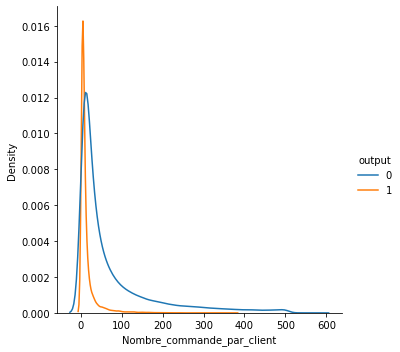

In [134]:
sns.displot(df_churn, x="Nombre_commande_par_client", hue = "output", kind = "kde")

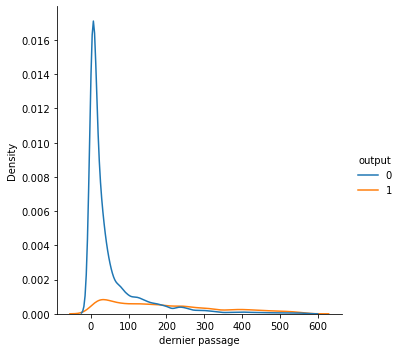

In [98]:
sns.displot(df_churn, x="dernier passage", hue = "output", kind = "kde")

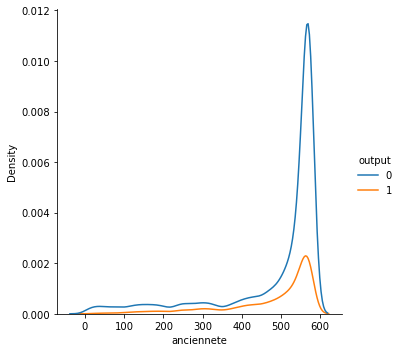

In [78]:
sns.displot(df_churn, x="anciennete", hue = "output", kind = "kde")

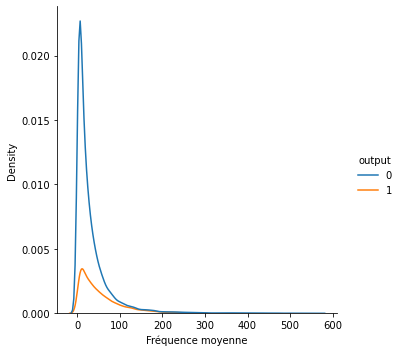

In [79]:
#sns.displot(df_churn, x="Fréquence moyenne", bins=20, hue = "output", multiple="stack")
sns.displot(df_churn, x="Fréquence moyenne", hue = "output", kind = "kde")

(-1000.0, 10000.0)

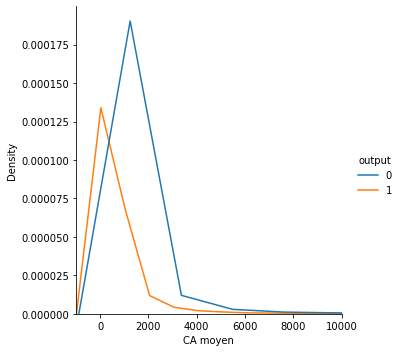

In [175]:
#sns.displot(df_churn, x="CA moyen", bins=20, hue = "output", multiple="stack")
sns.displot(df_churn, x="CA moyen", hue = "output", kind = "kde")
plt.xlim(-1000, 10000)

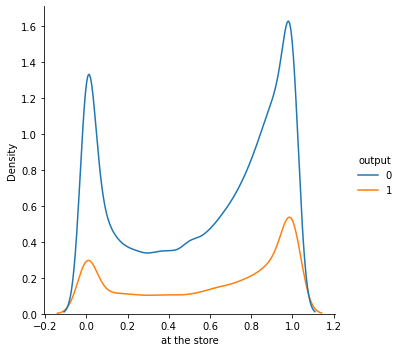

In [81]:
sns.displot(df_churn, x="at the store", hue = "output", kind = "kde")

(-0.4, 0.4)

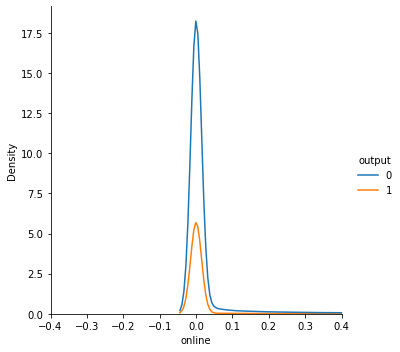

In [82]:
sns.displot(df_churn, x="online", hue = "output", kind = "kde")
plt.xlim(-0.4, 0.4)

(-10.0, 10.0)

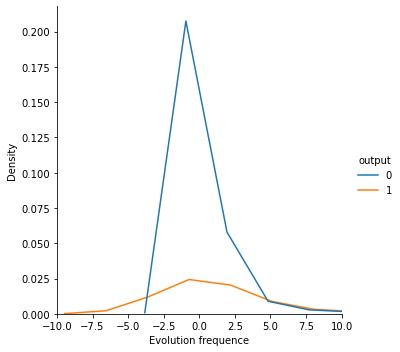

In [99]:
sns.displot(df_churn, x="Evolution frequence", hue = "output", kind = "kde")
plt.xlim(-10, 10)

(-0.2, 0.2)

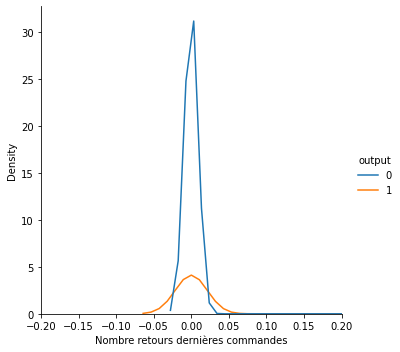

In [100]:
sns.displot(df_churn, x="Nombre retours dernières commandes", hue = "output", kind = "kde")
plt.xlim(-0.2, 0.2)

(-10.0, 10.0)

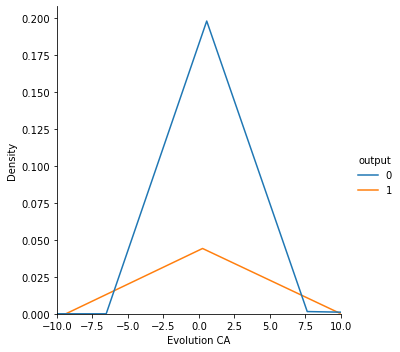

In [102]:
sns.displot(df_churn, x="Evolution CA", hue = "output", kind = "kde")
plt.xlim(-10, 10)

(-10.0, 10.0)

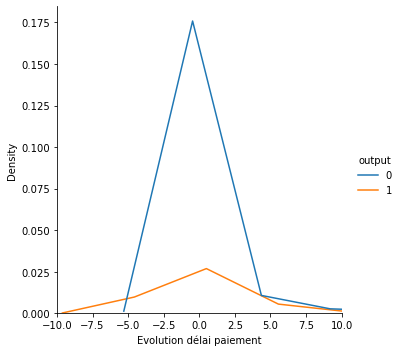

In [104]:
sns.displot(df_churn, x="Evolution délai paiement", hue = "output", kind = "kde")
plt.xlim(-10, 10)

A ce stade, les différences entre les deux états des clients sont très difficilement perceptibles. Les features prises séparément n'ont pas l'air d'expliciter très clairement l'état des clients.

## 3.4 Feature selection <a class="anchor" id="section_3_4"></a>

In [176]:
X = df_churn[["dernier passage", "anciennete", "Nombre_commande_par_client", "at the store", "by phone", "online", "other", "during the visit of a sales rep", "CA moyen", "Fréquence moyenne", "Evolution frequence", "Nombre retours dernières commandes", "Evolution CA", "Evolution délai paiement"]]
y = df_churn[["output"]]

<AxesSubplot:>

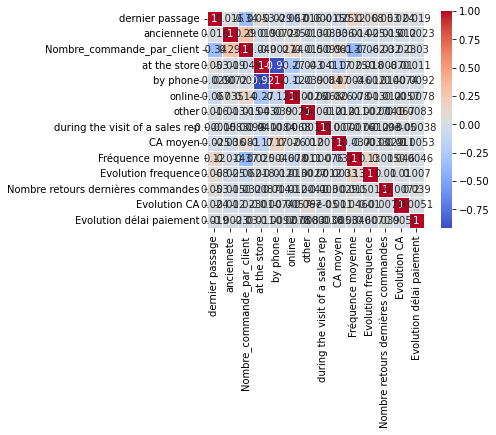

In [177]:
cor = X.corr() 
sns.heatmap(cor, square = True, cmap="coolwarm",linewidths=.5,annot=True)

## 3.5 Normalize data <a class="anchor" id="section_3_5"></a>

In [178]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-0.14072693,  0.41455663, -0.50672163, -0.61421221,  0.74362969,
        -0.25292572, -0.06706355, -0.0450278 , -0.18879656,  0.31499361,
        -0.18803756, -0.10774418, -0.1269194 , -0.08399641],
       [-0.69278134,  0.65132771,  4.86876625, -1.47165566,  1.11539541,
         1.02388958, -0.06706355, -0.0450278 ,  2.00391611, -0.72961792,
        -0.13775546, -0.10774418, -0.08396034, -0.12600643],
       [-0.66730191,  0.64392862,  2.53064754,  0.4273828 , -0.33127354,
        -0.25292572, -0.06706355, -0.0450278 , -0.04556656, -0.70794101,
        -0.1597452 , -0.10774418, -0.04322116, -0.08892409],
       [-0.61634304,  0.2813729 , -0.48487005,  0.18610396, -0.08227906,
        -0.25292572, -0.06706355, -0.0450278 , -0.12228956,  0.28508852,
         0.29664659, -0.10774418, -0.12592677, -0.14415382],
       [-0.67579505,  0.65132771, -0.01506115,  0.18827284, -0.08451729,
        -0.25292572, -0.06706355, -0.0450278 , -0.11844674, -0.49519312,
        -0.07338449, -0.10

## 3.6 Train test split <a class="anchor" id="section_3_6"></a>

In [179]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)

## 3.7 Logistic Regression <a class="anchor" id="section_3_7"></a>

Nous essayons pour commencer un premier algorithme de regression logistique.

In [180]:
lrmodel=LogisticRegression(solver='liblinear',  class_weight= "balanced").fit(X_train,y_train.values.ravel())

In [181]:
print(lrmodel.coef_)

[[ 1.04151557e+00  3.01328847e-02 -1.53311054e+00  1.79488566e-02
  -1.78300843e-02 -1.07664165e-03  5.54299618e-03 -1.36299950e-02
   2.70827199e-02  1.50899990e-01  2.30913763e-01  1.01917119e-01
  -1.05810736e-02  3.15056366e-02]]


In [182]:
y_pred=lrmodel.predict(X_test)

In [183]:
# Evaluate the model
#p_pred = lrmodel.predict_proba(X_test)
#print(p_pred)
conf_m = confusion_matrix(y_test, y_pred)
print(conf_m)
report = classification_report(y_test, y_pred)
print(report)

[[16300  4237]
 [ 1499  4498]]
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     20537
           1       0.51      0.75      0.61      5997

    accuracy                           0.78     26534
   macro avg       0.72      0.77      0.73     26534
weighted avg       0.83      0.78      0.80     26534



Nous pouvons voir, notamment avec les termes de Precision et Recall que les performances ne sont pas géniales. Cependant, pour un premier travail exploratoire, l'algorithme permet de détecter un nombre acceptable de client qui vont potentiellement churner et d'agir pour éviter leur départ.

## 3.8 Support Vector Machine <a class="anchor" id="section_3_8"></a>

Essayons avec un algorithme de SVM pour voir si les performances peuvent être meilleures.

In [192]:
svmmodel=svm.SVC(kernel='rbf', class_weight= "balanced")
svmmodel.fit(X_train,y_train.values.ravel())
y_pred=svmmodel.predict(X_test)

In [193]:
# Evaluate the model
#p_pred = lrmodel.predict_proba(X_test)
#score_ = lrmodel.score(X_test, y_test)
conf_m = confusion_matrix(y_test, y_pred)
print(conf_m)
report = classification_report(y_test, y_pred)
print(report)

[[15674  4863]
 [  730  5267]]
              precision    recall  f1-score   support

           0       0.96      0.76      0.85     20537
           1       0.52      0.88      0.65      5997

    accuracy                           0.79     26534
   macro avg       0.74      0.82      0.75     26534
weighted avg       0.86      0.79      0.80     26534



Cette fois-ci, nous constatons de meilleurs résultats en terme de Precision, et de Recall pour la classe 1. Ces résultats paraissent acceptables, car nous constatons que nous détectons trop de chruners, mais nous n'en manquons que très peu. Nous allons donc conserver cette algorithme pour évaluer ses gains potentiels pour ClientCo.

## 3.9 K Nearest Neighbor <a class="anchor" id="section_3_9"></a>

Cette méthode peut être intéressante pour classifier nos données d'une manière totalement différente. Cependant, il faudrait réaliser une boucle for pour itérer et tester différentes valeurs de n_neighbors. Ces valeurs peuvent en effet grandement affecter les résultats. Nous nous sommes donc contentés ici d'essayer de type d'algorithme en fixant n_neighbors à 50, pour voir les résultats proposés par ce type d'algorithme.

In [189]:
knnmodel=KNeighborsClassifier(n_neighbors=50).fit(X_train,y_train.values.ravel())
y_pred=knnmodel.predict(X_test)
conf_m = confusion_matrix(y_test, y_pred)
print(conf_m)
report = classification_report(y_test, y_pred)
print(report)

[[19299  1238]
 [ 3091  2906]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     20537
           1       0.70      0.48      0.57      5997

    accuracy                           0.84     26534
   macro avg       0.78      0.71      0.74     26534
weighted avg       0.83      0.84      0.83     26534



Contrairement aux algorithmes précédents, celui-ci privlégie la Precision au Recall. 

## 3.10 Random Forest <a class="anchor" id="section_3_10"></a>

Le Ranfom Forest est un algorithme difficilement explicable, tout comme les algorithmes de Deep Learning. Nous ne prendrons pas cet algorithme pour notre choix final. Nous avons juste décidé de l'implémeter pour voir les performances que ce type d'algorithme peut avoir par rapport aux autres.

In [186]:
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 2020)
rfmodel.fit(X_train, y_train.values.ravel())
y_pred=dtmodel.predict(X_test)
conf_m = confusion_matrix(y_test, y_pred)
print(conf_m)
report = classification_report(y_test, y_pred)
print(report)

[[17985  2552]
 [ 1815  4182]]
              precision    recall  f1-score   support

           0       0.91      0.88      0.89     20537
           1       0.62      0.70      0.66      5997

    accuracy                           0.84     26534
   macro avg       0.76      0.79      0.77     26534
weighted avg       0.84      0.84      0.84     26534



Nous pouvons constater de meilleures performances avec cette algorithme, qui gagne en Recall et Precision. C'est ce à quoi nous nous attendions, dû à la complexité supérieure de ce genre de modèle.

## 3.11 GradientBoostingRegressor <a class="anchor" id="section_3_11"></a>

Comme pour le Random Forest, le Gradient Boosting ne dispose pas d'une explicabilité immédiate. Il faudrait un temps supplémentaire pour comprendre l'importance des features dans les prises de décision. Nous le mettons en place uniquement dans le but de voir de possibles améliorations dans les prédictions.

In [187]:
gbrmodel = GradientBoostingRegressor(n_estimators = 100, max_depth = 3, min_samples_split = 5, learning_rate = 0.01, loss = 'squared_error')
gbrmodel.fit(X_train, y_train.values.ravel())
y_pred=gbrmodel.predict(X_test)

In [188]:
threshold = 0.3
pred_class =  (y_pred >= threshold).astype('int')
conf_m = confusion_matrix(y_test, pred_class)
print(conf_m)
report = classification_report(y_test, pred_class)
print(report)

[[16843  3694]
 [ 1212  4785]]
              precision    recall  f1-score   support

           0       0.93      0.82      0.87     20537
           1       0.56      0.80      0.66      5997

    accuracy                           0.82     26534
   macro avg       0.75      0.81      0.77     26534
weighted avg       0.85      0.82      0.83     26534



En jouant sur le seuil, nous pouvons décider de la précision de notre algorithme sur la détection des churners. Nous avons décider ici de nous positionner dans une situation où beaucoup de churners étaient détéctés pour ne pas en manquer, quitte à dépenser plus d'argent dans des campagnes marketing et autres moyens pour les retenir.

# 4. Evaluation performances <a class="anchor" id="chapter4"></a>

Dans cette partie, nous évaluons quelques grandeurs dans l'optique de quantifier l'impact de notre algorithme et les gains potentiellement réalisés.

In [194]:
#Evaluation de la part du CA des churners
df_ca2 = df_churn2[["sales_net", "client_id"]]
df_ca2 = df_ca2.groupby("client_id").agg("sum")
df_ca2 = df_ca2.merge(df_output, how='left', on='client_id')

df_ca_churners = df_ca2.loc[df_ca2["output"]==1]
ca_churners = df_ca_churners.sales_net.sum()
ca_tot = df_ca2.sales_net.sum()
print(f'Part du CA des churners = {100*ca_churners/ca_tot}%')

nb_churners = df_ca_churners.output.count()
print(f'nombre churners = {nb_churners}')
nb_client = df_ca2.output.count()
print(f'nombre client = {nb_client}')
print(f'part des churners = {100*nb_churners/nb_client}%')

Part du CA des churners = 5.373359049057315%
nombre churners = 29978
nombre client = 132670
part des churners = 22.595914675510667%


In [195]:
#calcul du CA de 2018
df_ca_an_chan = df_data[["date_order", "sales_net"]]
df_ca_an_chan["year_order"] = pd.to_datetime(df_ca_an_chan["date_order"]).dt.year
df_ca_2018 = df_ca_an_chan.loc[df_ca_an_chan["year_order"]==2018]
ca_2018 = df_ca_2018.sales_net.sum()
print(ca_2018)

C:\Users\antoi\AppData\Local\Temp\ipykernel_11936\1633093950.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca_an_chan["year_order"] = pd.to_datetime(df_ca_an_chan["date_order"]).dt.year


4627496390.494277


In [197]:
#on fixe un seuil, pour déterminer les clients que l'on va cibler pour les conserver
seuil_ca = 3000
df_ca_churners_to_keep = df_ca_churners.loc[df_ca_churners["sales_net"]>seuil_ca]
nb_churners_to_keep = df_ca_churners_to_keep.client_id.count()
print(f'Nombre de personnes à contacter : {nb_churners_to_keep}')
print(f'Cela représente {100*nb_churners_to_keep/nb_churners}% des clients qui churnent')

Nombre de personnes à contacter : 15277
Cela représente 50.96070451664554% des clients qui churnent


Nous sommes donc capables de détecter 88% des churners par notre algorithme. Nous ne pouvons pas intervenir sur tous ces clients. Parmi ceux-ci, en ne prenant que les plus gros acheteurs (CA historique >3000€), nous devons en contacter 50%.  
Il nous reste donc à calculer les gains que l'on réaliserait en mettant en place des stratégies pour conserver ces clients. C'est celà que nous développerons dans notre présentation.

# 5. Conclusion générale <a class="anchor" id="chapter5"></a>

Nous avons dans un premier temps analysé le business de ClientCo et son activité, pour comprendre le nombre de clients, de produits, la diversité des canaux de distribution, ... Nous avons pu constater que ClientCo est une très grosse entreprise avec beaucoup de références de produits, et beaucoup de clients. Elle possède donc de nombreuses données qui sont nécessaires pour comprendre les clients, les cibler, et les analyser.  
Nous avons décidé de mettre en place un algorithme de prévision de churn, car c'est un use case facilement implémentable, et avec des résultats et une valeur ajoutée importante. En essayant différents algorithmes de classificiation, nous avons retenu l'algorithme de SVM, qui permet de maximiser la marge entre les deux classes. Cet algorithme nous semblait le plus adapter afin de ne pas rater trop de clients qui vont churner, quitte à en détecter trop. Nous avons obtenu les performances suivantes avec cet algorithme : une Precision de 0.88, un Recall de 0.79 et un f1-score de 0.80. Ces performances peuvent évidemment être améliorées, mais elles nous paraissent suffisantes dans un premier temps pour proposer un Proof of Value à ClientCo, et lui montrer les économies qu'il pourra réaliser.